In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_val_score, RepeatedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer, TransformedTargetRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from category_encoders import TargetEncoder
import sklearn
import zipfile
import warnings
from sklearn.exceptions import ConvergenceWarning
from pandas.core.common import SettingWithCopyWarning

In [71]:
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Unzip data

In [55]:
with zipfile.ZipFile('housedata.zip', 'r') as z:
    z.extractall('./')

In [3]:
data = pd.read_csv('data.csv')
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


# 2.1 
Determine which features are continuous vs categorical. Drop rows without a valid sales
price.

Drop the date column and all rows with prices <= 0

In [4]:
data = data[data.price > 0.0]
data = data.drop(columns='date')

Get the target 'price' column and remove it from the dataframe. Remove 'street' and 'country' columns

In [5]:
price = data['price']
data = data.drop(columns=['price', 'country', 'street'])

The features which are continuous include sqft_living, sqft_lot, sqft_above, sqft_basement, as well as yr_built and yr_renovated. The features which are categorical include waterfront, view, condition, statezip, and city. The features bedrooms, bathrooms, and floors can be defined as discrete features. As you cannot have an infinite number of inbetween values (i.e between 1 and 1.5 bathrooms, you cannot have 1.25), and the number of categories are finite for these features (i.e the number of unique values is a small finite number), they have been treated as categorical for the purpose of this assignment. As street and country are not useful for the task of predicting price, these columns have been dropped from the dataframe.

## 2.2 
Visualize the univariate distribution of each continuous feature, and the distribution of the
target. Do you notice anything? Is there something that might require special treatment?

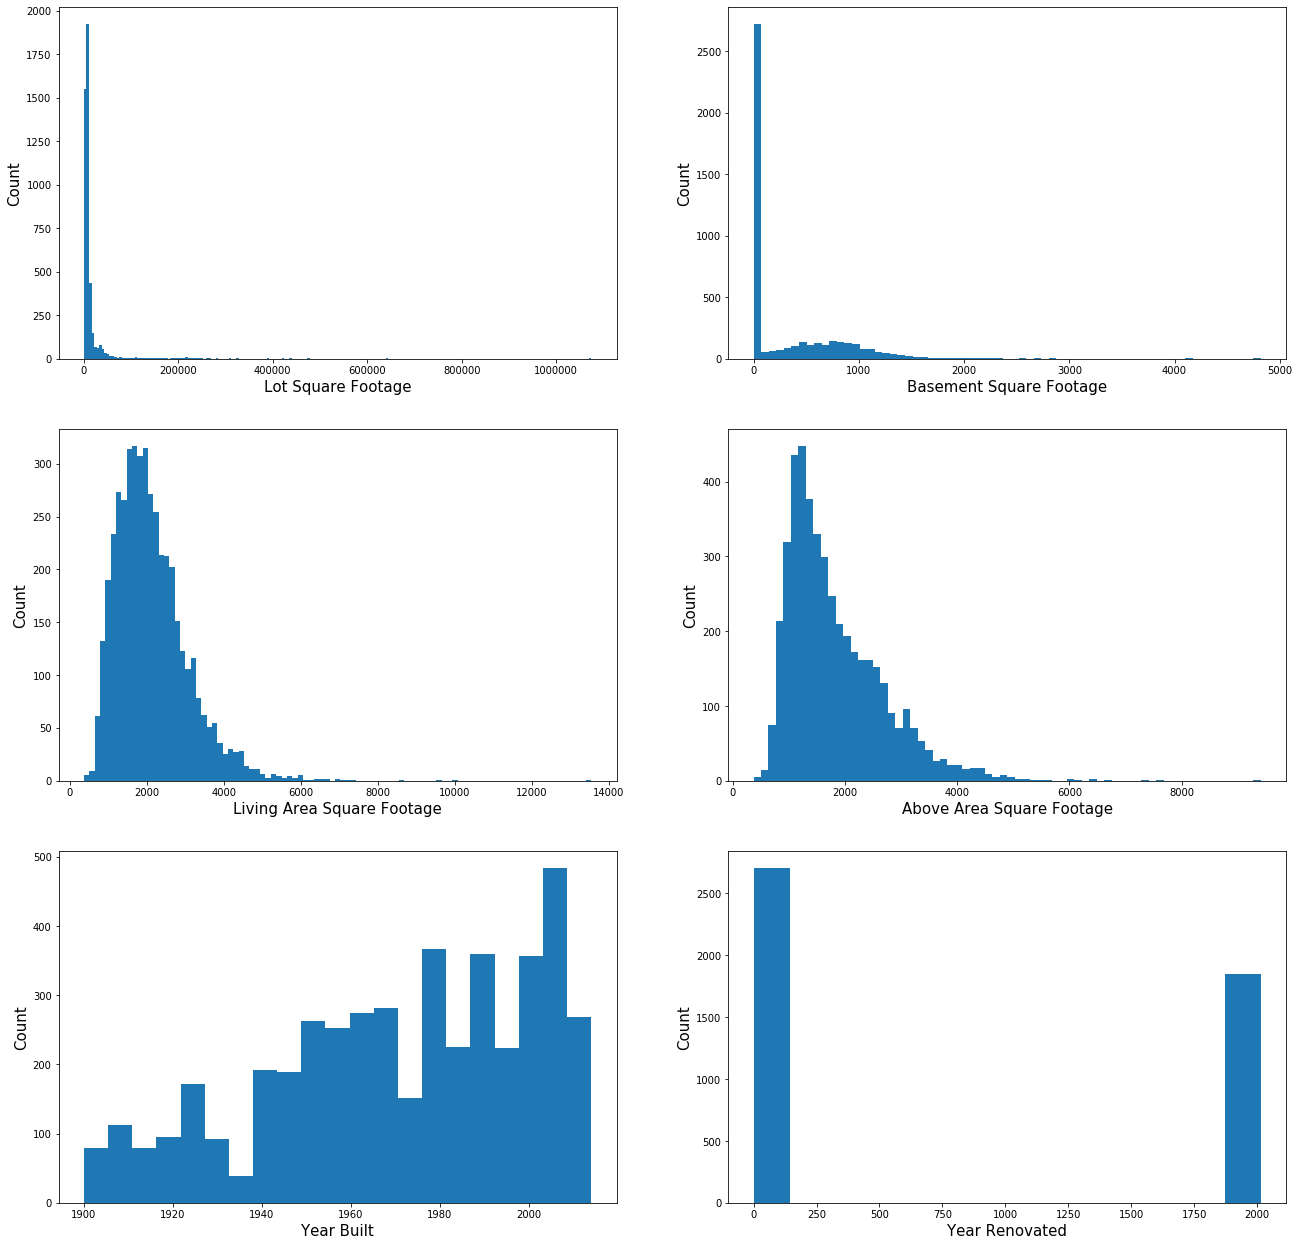

In [7]:
fig, ax = plt.subplots(3, 2, figsize=(22,22))
ax1, ax2, ax3, ax4, ax5, ax6 = ax.ravel()

ax1.hist(data['sqft_lot'], bins=200)
ax1.set_ylabel('Count', fontsize=15)
ax1.set_xlabel('Lot Square Footage', fontsize=15)

ax2.hist(data['sqft_basement'], bins='auto')
ax2.set_ylabel('Count', fontsize=15)
ax2.set_xlabel('Basement Square Footage', fontsize=15)

ax3.hist(data['sqft_living'], bins='auto')
ax3.set_ylabel('Count', fontsize=15)
ax3.set_xlabel('Living Area Square Footage', fontsize=15)

ax4.hist(data['sqft_above'], bins='auto')
ax4.set_ylabel('Count', fontsize=15)
ax4.set_xlabel('Above Area Square Footage', fontsize=15)

ax5.hist(data['yr_built'], bins='auto')
ax5.set_ylabel('Count', fontsize=15)
ax5.set_xlabel('Year Built', fontsize=15)

ax6.hist(data['yr_renovated'], bins='auto')
ax6.set_ylabel('Count', fontsize=15)
ax6.set_xlabel('Year Renovated', fontsize=15)
plt.show()

Visualize the target

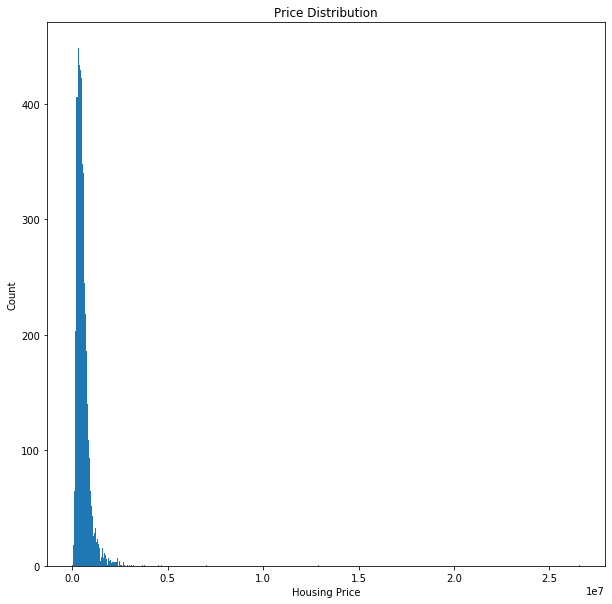

In [10]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
ax.hist(price, bins=500)
ax.set_xlabel('Housing Price')
ax.set_ylabel('Count')
ax.set_title('Price Distribution')
plt.show()

Do you notice anything? Is there something that might require special treatment?

Looking at the distributions of the continuous data and the target, one obvious difference is the range of values presented. For example, 'sqft_lot' has a right tail with values which are in the range of 20000, which is signifcantly higher than majority of the values/ranges of the other continuous features. Therefore, scaling the data will be important. Furthermore, 'sqft_basement' has a significant number of 0's and therefore, may require special treatment. In order to deal with this, an additional column has been added (see below) which is a categorical feature, encoding whether or not there a basement (i.e. 1 if there is a basement/non-zero value for the 'sqft_basement' and 0 otherwise). Also, looking at the year renovated, there is also a column full of zeros. When comparing this to the original data.dat file, the 0's in this column have been used to replace 'NaN' and therefore, imputing will be needed to replace the 0's in the year renovated column. Finally, the target variable shows a skew in its distribution. To deal with this, a log-transformation was considered and used but as it did not help with the regression results, it was not used for parts 2.4-2.6

Add an additional 'has_basement' column

In [11]:
data['has_basement'] = 0
data.loc[data['sqft_basement'] > 0, 'has_basement'] = 1

## 2.3 
Visualize the dependency of the target on each continuous feature (2d scatter plot).

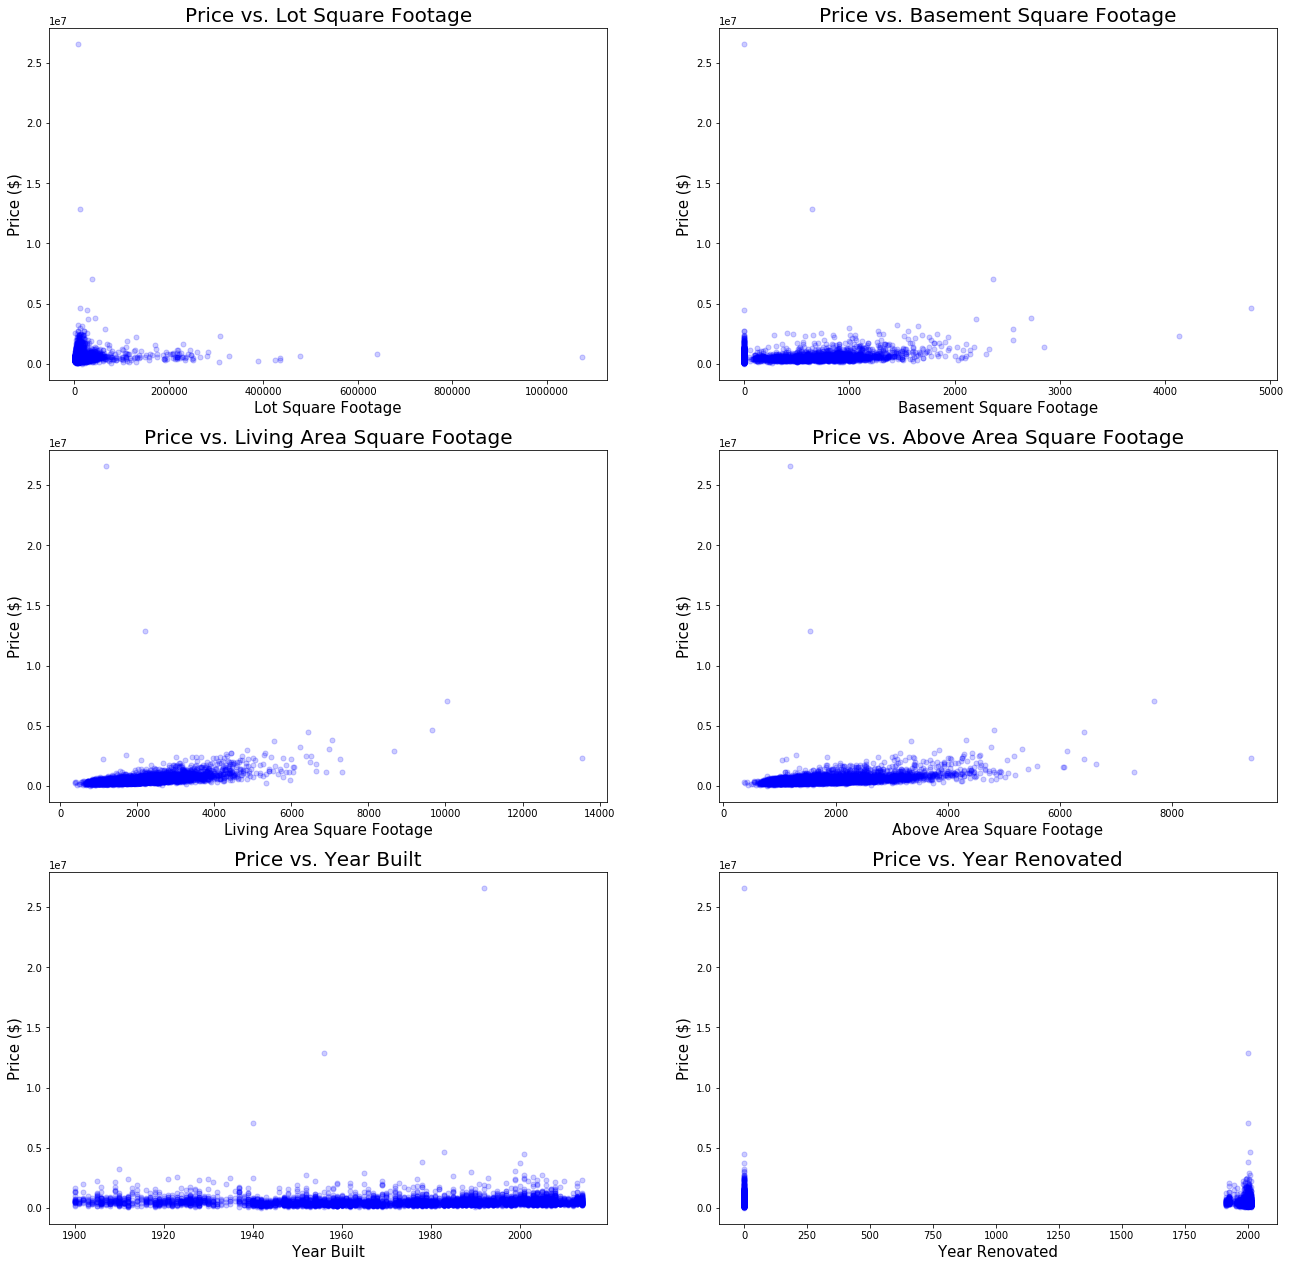

In [12]:
fig, ax = plt.subplots(3, 2, figsize=(22,22))
ax1, ax2, ax3, ax4, ax5, ax6 = ax.ravel()

ax1.plot(data['sqft_lot'], price, 'bo', alpha=0.2, markersize=5)
ax1.set_ylabel('Price ($)', fontsize=15)
ax1.set_xlabel('Lot Square Footage', fontsize=15)
ax1.set_title('Price vs. Lot Square Footage', fontsize=20)

ax2.plot(data['sqft_basement'], price, 'bo', alpha=0.2, markersize=5)
ax2.set_ylabel('Price ($)', fontsize=15)
ax2.set_xlabel('Basement Square Footage', fontsize=15)
ax2.set_title('Price vs. Basement Square Footage', fontsize=20)

ax3.plot(data['sqft_living'], price, 'bo', alpha=0.2, markersize=5)
ax3.set_ylabel('Price ($)', fontsize=15)
ax3.set_xlabel('Living Area Square Footage', fontsize=15)
ax3.set_title('Price vs. Living Area Square Footage', fontsize=20)

ax4.plot(data['sqft_above'], price, 'bo', alpha=0.2, markersize=5)
ax4.set_ylabel('Price ($)', fontsize=15)
ax4.set_xlabel('Above Area Square Footage', fontsize=15)
ax4.set_title('Price vs. Above Area Square Footage', fontsize=20)

ax5.plot(data['yr_built'], price, 'bo', alpha=0.2, markersize=5)
ax5.set_ylabel('Price ($)', fontsize=15)
ax5.set_xlabel('Year Built', fontsize=15)
ax5.set_title('Price vs. Year Built', fontsize=20)

ax6.plot(data['yr_renovated'], price, 'bo', alpha=0.2, markersize=5)
ax6.set_ylabel('Price ($)', fontsize=15)
ax6.set_xlabel('Year Renovated', fontsize=15)
ax6.set_title('Price vs. Year Renovated', fontsize=20)
plt.show()

In [13]:
# Separate features based on the type of preprocessing required
area = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
continuous = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']
categorical = ['waterfront', 'city', 'condition', 'view', 'has_basement', 'bedrooms', 'bathrooms', 'floors']
state = ['statezip']
year = ['yr_built', 'yr_renovated']

## 2.4
Split data in training and test set. Do not use the test-set unless for a final evaluation in 2.5.
Use ColumnTransformer and pipeline to encode categorical variables (your choice of
OneHotEncoder or another one from the categorical_encoder package, or both). Impute missing
values using SimpleImputer. Evaluate Linear Regression (OLS), Ridge, Lasso and ElasticNet
using cross-validation with the default parameters. Does scaling the data (within the pipeline)
with StandardScaler help? Use the preprocessing that works best going forward.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data, price, shuffle=True, random_state=0)
cv_strategy = KFold(n_splits=10, shuffle=True, random_state=0)

As part of the preprocessing, impute all missing year values with the most frequent. Based on the data.dat file, this is for any '0' value in the yr_renovated columns. Use target encoding for the statezip column. Finally, impute any missing categorical data with the most frequent and one-hot encode all categories.

In [15]:
yr_processing = Pipeline([('impute', SimpleImputer(strategy='most_frequent', missing_values=0))])
cat_processing = Pipeline([('impute', SimpleImputer(strategy='most_frequent', missing_values=0)),
                           ('encode', preprocessing.OneHotEncoder(handle_unknown='ignore'))])
target_processing = Pipeline([('encode', TargetEncoder())])
preprocess = make_column_transformer((yr_processing, year),
                                     (cat_processing, categorical),
                                     (target_processing, state),
                                     remainder='passthrough')

In [22]:
lin_reg_pipe = make_pipeline(preprocess, LinearRegression())
lin_reg = cross_val_score(lin_reg_pipe, X_train, y_train, cv=cv_strategy)
np.mean(lin_reg)

0.6212909555143789

In [23]:
ridge_pipe = make_pipeline(preprocess, Ridge(max_iter=5000))
ridge = cross_val_score(ridge_pipe, X_train, y_train, cv=cv_strategy)
np.mean(ridge)

0.5732155870020962

In [24]:
lasso_pipe = make_pipeline(preprocess, Lasso(max_iter=5000))
lasso = cross_val_score(lasso_pipe, X_train, y_train, cv=cv_strategy)
np.mean(lasso)

0.6190663576778122

In [26]:
en_pipe = make_pipeline(preprocess, ElasticNet(max_iter=5000))
en = cross_val_score(en_pipe, X_train, y_train, cv=cv_strategy)
np.mean(en)

0.6084515293708403

Add scaling to data

To ensure the years are first appropriately imputed and then scaled with the rest of the continuous data, imputing years is done outside the column transformer.

In [72]:
imputer = SimpleImputer(strategy='most_frequent', missing_values=0)
imputed_years = imputer.fit_transform(X_train[year])
X_train['yr_renovated'] = np.where(X_train['yr_renovated'] == 0, imputed_years[:,1], imputed_years[:,1])
X_train['yr_built'] = np.where(X_train['yr_built'] == 0, imputed_years[:,0], imputed_years[:,0])

In [77]:
#year_processing = Pipeline([('scale', preprocessing.StandardScaler())])
cont_processing = Pipeline([('scale', preprocessing.StandardScaler())])
target_processing = Pipeline([('encode', TargetEncoder()), ('scale', preprocessing.StandardScaler())])
preprocess_with_ss = make_column_transformer((cat_processing, categorical),
                                     (cont_processing, continuous),
                                     (target_processing, state),
                                     remainder='passthrough')

In [78]:
ct = preprocess_with_ss.fit(X_train,y_train)
new = ct.transform(X_train)
new = pd.DataFrame(new.toarray())
new

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.392679,-0.212339,-1.215447,-0.660367,-0.536083,-1.023300,0.289193
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.232140,-0.195953,0.102108,-0.660367,0.643359,0.816381,1.021622
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.604286,-0.111544,-0.325207,1.826299,-0.300195,0.154096,0.463342
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.203949,0.133657,2.867788,-0.660367,0.879248,0.154096,3.170040
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.158952,0.205989,-0.847481,1.204632,-1.142654,0.006921,-0.020956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3408,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-0.890824,-0.354938,-0.645694,-0.660367,1.216231,0.154096,0.134169
3409,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.204484,-0.250247,-1.001790,-0.660367,-0.502385,0.227683,-0.492727
3410,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.043944,-0.051831,0.315766,-0.660367,0.542264,0.154096,0.289424
3411,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.991132,0.495832,0.303896,1.483310,-0.704575,-1.096887,5.941834


In [79]:
lin_reg_pipe = make_pipeline(preprocess_with_ss, LinearRegression())
lin_reg_ss = cross_val_score(lin_reg_pipe, X_train, y_train, cv=cv_strategy)
np.mean(lin_reg_ss)

0.6201984318511049

In [80]:
ridge_pipe = make_pipeline(preprocess_with_ss, Ridge(max_iter=5000))
ridge_ss = cross_val_score(ridge_pipe, X_train, y_train, cv=cv_strategy)
np.mean(ridge_ss)

0.6250918138943442

In [81]:
lasso_pipe = make_pipeline(preprocess_with_ss, Lasso(max_iter=5000))
lasso_ss = cross_val_score(lasso_pipe, X_train, y_train, cv=cv_strategy)
np.mean(lasso_ss)

0.619067677664388

In [46]:
en_pipe = make_pipeline(preprocess_with_ss, ElasticNet(max_iter=5000))
en = cross_val_score(en_pipe, X_train, y_train, cv=cv_strategy)
np.mean(en)

0.5966301719135211

Scaling makes an insignificant change in the case of ordinary linear regression and lasso regression. It does however, result elastic net becoming slightly worse while ridge regression shows the greatest change, improving significantly from when no scaling was used.

# 2.5 
Tune the parameters of the models using GridSearchCV. Do the results improve? Visualize
the dependence of the validation score on the parameters for Ridge, Lasso and ElasticNet.

In [82]:
ridge_pipe_new = make_pipeline(preprocess_with_ss, Ridge(max_iter=5000))
param_grid = {'ridge__alpha': np.logspace(-4,2,7)}
ridge_grid = GridSearchCV(ridge_pipe_new, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid.fit(X_train, y_train)
ridge_grid.best_score_

0.631457151756859

In [83]:
lasso_pipe_new = make_pipeline(preprocess_with_ss, Lasso(max_iter=5000))
param_grid = {'lasso__alpha': np.logspace(-3,3,7)}
lasso_grid = GridSearchCV(lasso_pipe_new, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
lasso_grid.fit(X_train, y_train)
lasso_grid.best_score_

0.6308637988095065

In [84]:
en_pipe_new = make_pipeline(preprocess_with_ss, ElasticNet(max_iter=5000))
param_grid = {'elasticnet__alpha': np.logspace(-3,3,7)}
en_grid = GridSearchCV(en_pipe_new, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
en_grid.fit(X_train, y_train)
en_grid.best_score_

0.6309612000354105

In [85]:
param_grid = {'elasticnet__l1_ratio': np.logspace(-3,0,7)}
en_grid_l1 = GridSearchCV(en_pipe_new, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
en_grid_l1.fit(X_train, y_train)
en_grid_l1.best_score_

0.619067677664388

In [86]:
print(ridge_grid.best_params_)
print(lasso_grid.best_params_)
print(en_grid.best_params_)
print(en_grid_l1.best_params_)

{'ridge__alpha': 100.0}
{'lasso__alpha': 1000.0}
{'elasticnet__alpha': 0.01}
{'elasticnet__l1_ratio': 1.0}


Evaluate on the best model on the test data

In [49]:
ridge_grid.score(X_test,y_test)

0.7137240936440593

In [97]:
imputed_years = imputer.transform(X_test[year])
X_test['yr_renovated'] = np.where(X_test['yr_renovated'] == 0, imputed_years[:,1], imputed_years[:,1])
X_test['yr_built'] = np.where(X_test['yr_built'] == 0, imputed_years[:,0], imputed_years[:,0])

In [98]:
ridge_grid.score(X_test,y_test)

0.713390069086755

Do the results improve?

By optimzing the regularization parameters through grid search, all of the cross validation results improve in comparison to when the default values were being used. This was seen for all three models (Lasso, Ridge, and Elastic Net). In the end, Ridge Regression showed the higest cross validation score, and the resulted on a test score above 0.7

In [90]:
ridge_df = pd.DataFrame(ridge_grid.cv_results_)
ridge_mean_test_score = ridge_df['mean_test_score']
ridge_mean_train_score = ridge_df['mean_train_score']
ridge_alpha_param = ridge_df['param_ridge__alpha']
ridge_std_train = ridge_df['std_train_score']

lasso_df = pd.DataFrame(lasso_grid.cv_results_)
lasso_mean_test_score = lasso_df['mean_test_score']
lasso_mean_train_score = lasso_df['mean_train_score']
lasso_alpha_param = lasso_df['param_lasso__alpha']

en_df = pd.DataFrame(en_grid.cv_results_)
en_mean_test_score = en_df['mean_test_score']
en_mean_train_score = en_df['mean_train_score']
en_alpha_param = en_df['param_elasticnet__alpha']

en_df_l1 = pd.DataFrame(en_grid_l1.cv_results_)
en_mean_test_score_l1 = en_df_l1['mean_test_score']
en_mean_train_score_l1 = en_df_l1['mean_train_score']
en_l1_param = en_df_l1['param_elasticnet__l1_ratio']

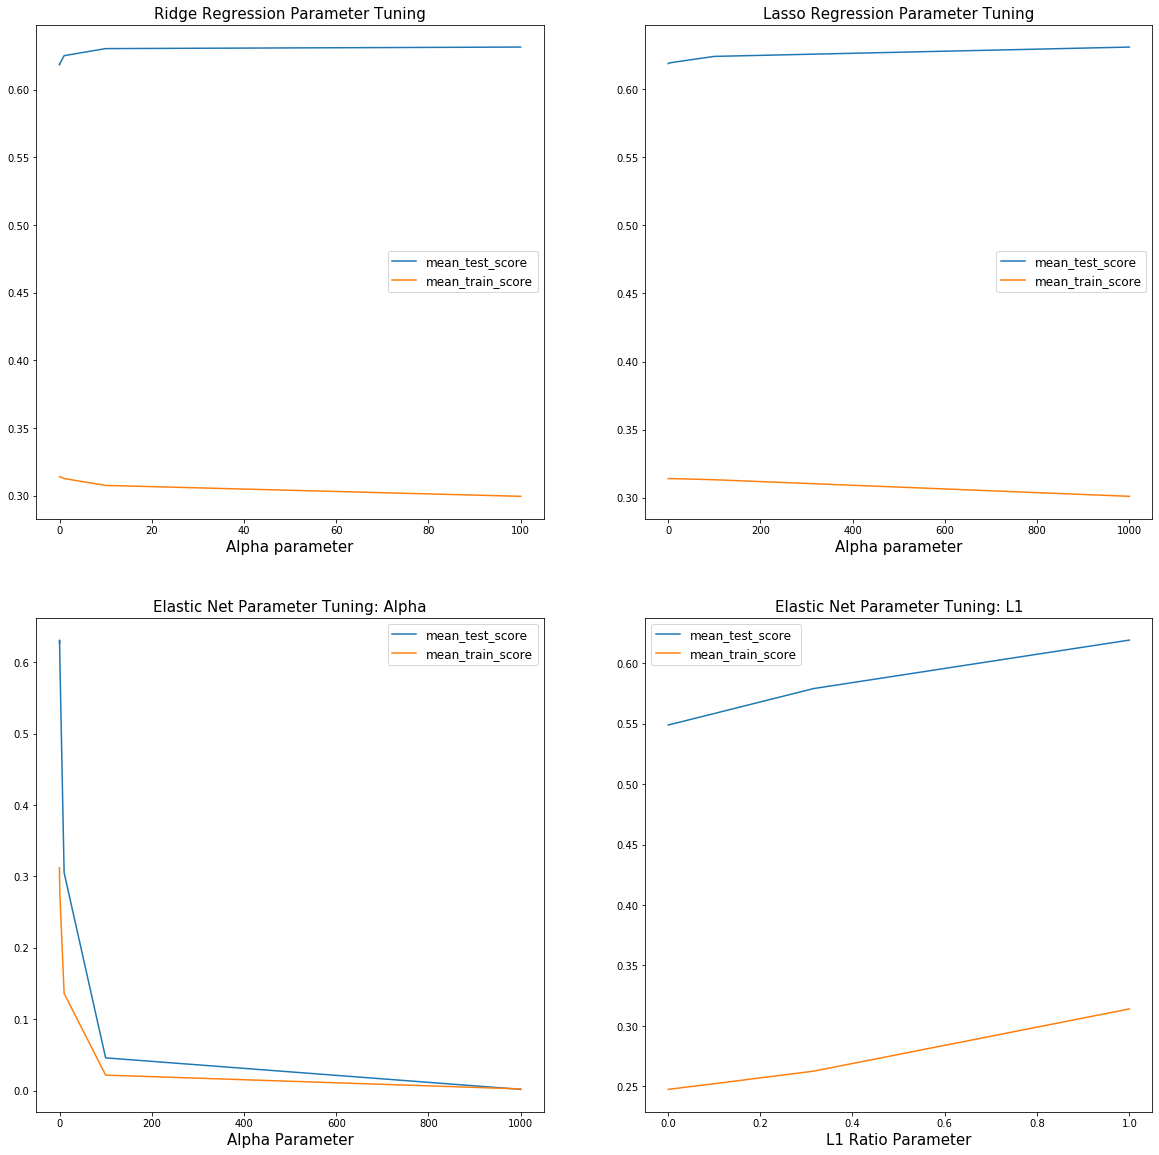

In [91]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
ax1, ax2, ax3, ax4 = ax.ravel()

ax1.plot(ridge_alpha_param, ridge_mean_test_score)
ax1.plot(ridge_alpha_param, ridge_mean_train_score)
ax1.legend(['mean_test_score', 'mean_train_score'], fontsize=12)
ax1.set_xlabel('Alpha parameter', fontsize=15)
ax1.set_title('Ridge Regression Parameter Tuning', fontsize=15)

ax2.plot(lasso_alpha_param, lasso_mean_test_score)
ax2.plot(lasso_alpha_param, lasso_mean_train_score)
ax2.legend(['mean_test_score', 'mean_train_score'], fontsize=12)
ax2.set_xlabel('Alpha parameter', fontsize=15)
ax2.set_title('Lasso Regression Parameter Tuning', fontsize=15)

ax3.plot(en_alpha_param, en_mean_test_score)
ax3.plot(en_alpha_param, en_mean_train_score)
ax3.legend(['mean_test_score', 'mean_train_score'],fontsize=12)
ax3.set_xlabel('Alpha Parameter', fontsize=15)
ax3.set_title('Elastic Net Parameter Tuning: Alpha', fontsize=15)

ax4.plot(en_l1_param, en_mean_test_score_l1)
ax4.plot(en_l1_param, en_mean_train_score_l1)
ax4.legend(['mean_test_score', 'mean_train_score'],fontsize=12)
ax4.set_xlabel('L1 Ratio Parameter', fontsize=15)
ax4.set_title('Elastic Net Parameter Tuning: L1', fontsize=15)

plt.show()

## 2.6 
Visualize the 20 most important coefficients of the resulting models. Do they agree on which
features are important?

In [92]:
enc = preprocessing.OneHotEncoder()
enc.fit_transform(X_train[categorical])
encoded_categories = list(enc.get_feature_names(categorical))
all_features = encoded_categories + continuous + state

In [93]:
best_ridge_pipe = make_pipeline(preprocess, Ridge(alpha=100))
best_ridge_pipe.fit(X_train,y_train)
best_lasso_pipe = make_pipeline(preprocess, Lasso(alpha=1000))
best_lasso_pipe.fit(X_train,y_train)
best_en_pipe = make_pipeline(preprocess, ElasticNet(alpha=0.01, l1_ratio=1))
best_en_pipe.fit(X_train,y_train)

best_ridge_coeff = best_ridge_pipe['ridge'].coef_
best_lasso_coeff = best_lasso_pipe['lasso'].coef_
best_en_coeff = best_en_pipe['elasticnet'].coef_

In [94]:
ridge_coeff_abs = [abs(x) for x in best_ridge_coeff]
ridge_coeff_pairs = zip(all_features, ridge_coeff_abs)
ridge_coeff_sorted = sorted(ridge_coeff_pairs, key=lambda x: x[1], reverse=True)
top_20_ridge = ridge_coeff_sorted[0:21]

lasso_coeff_abs = [abs(x) for x in best_lasso_coeff]
lasso_coeff_pairs = zip(all_features, lasso_coeff_abs)
lasso_coeff_sorted = sorted(lasso_coeff_pairs, key=lambda x: x[1], reverse=True)
top_20_lasso = lasso_coeff_sorted[0:21]

en_coeff_abs = [abs(x) for x in best_en_coeff]
en_coeff_pairs = zip(all_features, en_coeff_abs)
en_coeff_sorted = sorted(en_coeff_pairs, key=lambda x: x[1], reverse=True)
top_20_en = en_coeff_sorted[0:21]

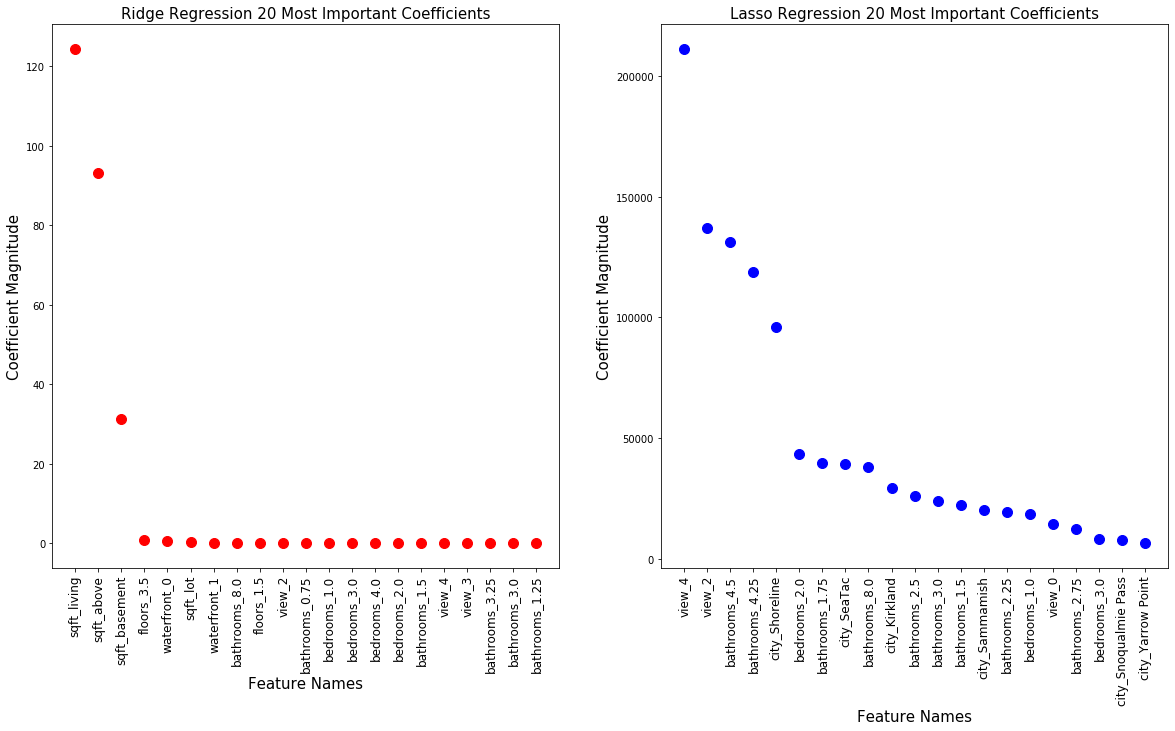

In [95]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax1, ax2 = ax.ravel()

names_ridge, coeff_ridge = zip(*top_20_ridge)
ax1.plot(coeff_ridge, 'ro', markersize='10')
ax1.set_xlabel('Feature Names',fontsize=15)
ax1.set_ylabel('Coefficient Magnitude',fontsize=15)
ax1.set_xticks(range(21))
ax1.set_xticklabels(names_ridge, rotation='vertical', fontsize=12)
ax1.set_title('Ridge Regression 20 Most Important Coefficients',fontsize=15)

names_lasso, coeff_lasso = zip(*top_20_lasso)
ax2.plot(coeff_lasso, 'bo', markersize='10')
ax2.set_xlabel('Feature Names', fontsize=15)
ax2.set_ylabel('Coefficient Magnitude', fontsize=15)
ax2.set_xticks(range(21))
ax2.set_xticklabels(names_lasso, rotation=90, fontsize=12)
ax2.set_title('Lasso Regression 20 Most Important Coefficients', fontsize=15)
plt.show()

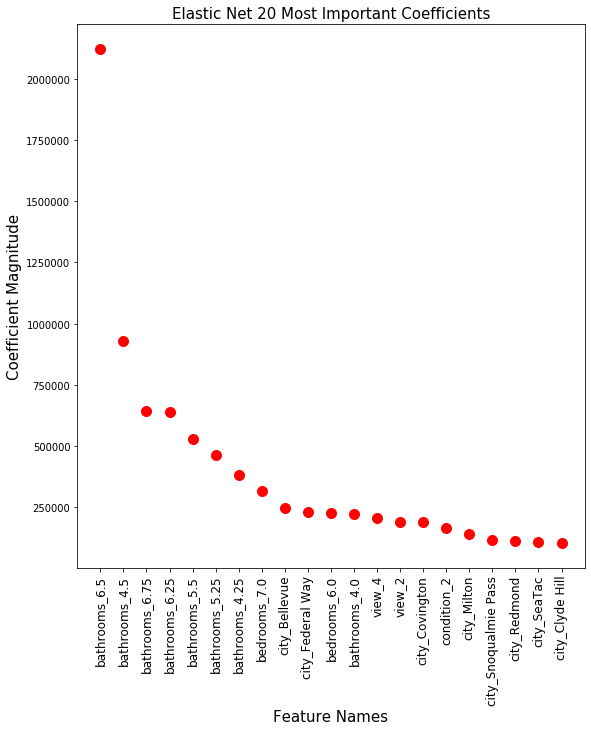

In [96]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax1, ax2 = ax.ravel()

names_en, coeff_en = zip(*top_20_en)
ax1.plot(coeff_en, 'ro', markersize='10')
ax1.set_xlabel('Feature Names',fontsize=15)
ax1.set_ylabel('Coefficient Magnitude',fontsize=15)
ax1.set_xticks(range(21))
ax1.set_xticklabels(names_en, rotation='vertical', fontsize=12)
ax1.set_title('Elastic Net 20 Most Important Coefficients',fontsize=15)
fig.delaxes(ax2)
plt.show()

Do they agree on which features are important?

The models emphasize importance on different features. For ridge regression, the most important is the sqft of living area while for Lasso, it is the number of bathrooms and the view. In contrast, elastic gives the greatest importance to bathrooms.